# **AhR agonist prediction_Data curation**





1.   Our goal is to build machine-learning based QSAR models to predict AhR agonists from their molecular structure.
2.   The models need to determine if a chemical is an AhR agonist or not and yield estimate for its EC10 value.

In [ ]:
!pip install rdkit
!pip install pubchempy
!pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 4.3 MB/s eta 0:00:00


In [ ]:
# Set up working directory
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)
# to restrict the float value to 3 dcimal places
pd.set_option('display.float_format',lambda x:'%.3f'%x)
import warnings
warnings.filterwarnings('ignore')

# import Chemoinformatic libraries
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
import pandas as pd
from rdkit.Chem import PandasTools

In [ ]:
#load an csv file into a dataframe using Pandas, from Georg
RawData = pd.read_csv('/content/drive/MyDrive/AhR/06/250303_AhR_All_individual_assay_data.csv')

## **Load evaluated data with AC50 and labels**

### **Summary**

1.   AC50: is the log concentration at relative 50% activiy of the experimental Top value
2.   AC_benchmark: AC_benchmark is the log concentration equals EC10 as 10% effect is our benchmark effect level
3.   Is_viability_assay: whether the endpoint was AhR activity (FALSE) or Cell viability (TRUE)

4. Call, log_Benchmark_concentration, and Activity_level are from the tcpl evaluations from CurveSurfer

5. All concentrations are in µM

6. From column K on everything was the evaluation from Georg

7. There are 16232 entries, with NaN values in 'Call_after_fit' column and 'Confidence' column

8. The number of chemicals with 'log_Benchmark_concentration' is different from 'AC50_fit'

9. There are Null in the column 'Call_after_fit'

10. All NULL cases in the column 'Call_after_fit' are inactive


In [ ]:
# Rename CAS with CASRN and use CASRN as the identifier to concatenate tables to append attributes in the following
# The column name of 'log_Benchmark_concentration' is 'non-logarithmic concentration', and concentrations from columns K to O are logarithmic
Data = RawData.rename(columns={"CAS": "CASRN",
                                "AC_benchmark": "AC_10",
                                "log_Benchmark_concentration": 'EC50_concentration'})

In [ ]:
# Remove object columns 'Concentrations' & 'Responses'
Data = Data.drop(['Activity_level', 'Concentrations', 'Responses', 'unit', 'Benchmark', 'unit_benchmark'], axis = 1)

## **Filter data**


### **Summary**

*   **Only need to look at chemicals with False in the column 'Is_viability'**

*   **The number of chemicals with Ture is the same as with False**

*   **After discussion with Georg, we decided to remove chemicals with confidence between 0 and 0.2. The known AhR agonists with confidence in this range will be selected as an in-house test dataset to evaluate the model performance.**

*   **The threshold can be set as > 0.2 to limit false positives in the training dataset. For the ML model, it allows a certain ratio of false positives.**

*  **The latest version resolves negative confidence value issues. However, chemicals with confidence between 0.4-0.7 also have AC10 values, whereas chemicals with confidence >0.7 will have AC10 values**




In [ ]:
df = Data[Data['Is_viability'] == False]

In [ ]:
#There are no duplicates for filtered chemicals.
df.duplicated(subset = 'CASRN').sum()

np.int64(0)

In [ ]:
df['Call_after_fit'].isnull().sum()

np.int64(0)

In [ ]:
# Function to create labeled barplots

def labeled_barplot(data, feature, perc = False, n = None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])            # Length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize = (count + 1, 5))
    else:
        plt.figure(figsize = (n + 1, 5))

    plt.xticks(rotation = 90, fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.ylabel('Count' , fontsize=24)
    ax = sns.countplot(
        data = data,
        x = feature,
        palette = "Paired",
        order = data[feature].value_counts().index[:n].sort_values(),
    )
    # Remove only the x-axis title (label)
    ax.set_xlabel('')
    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )                              # Percentage of each class of the category
        else:
            label = p.get_height()         # Count of each level of the category

        x = p.get_x() + p.get_width() / 2  # Width of the plot
        y = p.get_height()                 # Height of the plot

        ax.annotate(
            label,
            (x, y),
            ha = "center",
            va = "center",
            size = 16,
            xytext = (0, 5),
            textcoords = "offset points",
        )                                 # Annotate the percentage
    plt.tight_layout()  # Adjust layout to prevent label cutoff
    plt.savefig('Count of class groups for Tox21', dpi=300)  # dpi=300 for high resolution
    plt.show()                            # Show the plot

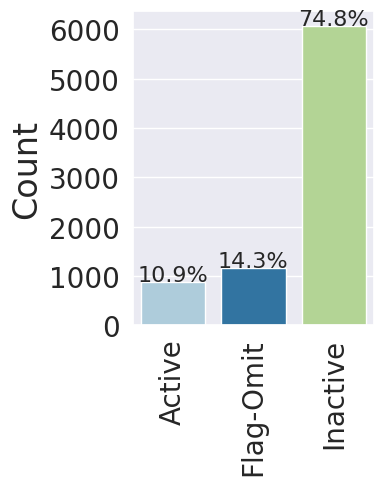

In [ ]:
labeled_barplot(df, "Call_after_fit", perc = True)

In [ ]:
Flag = df[df['Call_after_fit'] == 'Flag-Omit']

In [ ]:
Flag[Flag['Confidence'].isnull()]

,Compound,CASRN,Call,EC50_concentration,Endpoint,Is_viability,AC50_fit,Slope_fit,Top_fit,Bottom_fit,AC_10,Call_after_fit,Confidence,Plot_Nr
652,"1,2-Phenylenediamine",95-54-5,QC-Omit,NaN,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Flag-Omit,NaN,#653
764,"1,3-Dinitronaphthalene",606-37-1,Active,17.519,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Flag-Omit,NaN,#765
774,"1,3-Diphenylguanidine",102-06-7,Active,66.850,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Flag-Omit,NaN,#775
886,"1,5-Naphthalenediamine",2243-62-1,Flag-Omit,NaN,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Flag-Omit,NaN,#887
1858,"2,3-Benzofuran",271-89-6,QC-Omit,NaN,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Flag-Omit,NaN,#1859
2028,"2,4-Dichlorophenoxybutyric acid",94-82-6,Inactive,NaN,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Flag-Omit,NaN,#2029
2396,2-Amino-5-nitrophenol,121-88-0,Active,55.751,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Flag-Omit,NaN,#2397
2402,2-Amino-6-nitrobenzothiazole,6285-57-0,Active,65.897,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Flag-Omit,NaN,#2403
2916,"2-Nitro-1,4-phenylenediamine",5307-14-2,Active,44.221,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Flag-Omit,NaN,#2917
3792,"4,4'-Thiodianiline",139-65-1,Active,28.024,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Flag-Omit,NaN,#3793


The above 25 chemicals are special as their confidence values are NaN but assigned with Flag. It is possible that they don't have a fit. So it is hard to classify them.

Chemicals assigned with 'Active' in the 'Call_after_fit' column have confidence values ranging from 0.2 to 1.

Chemicals assigned with 'Inactive' in the 'Call_after_fit' column have confidence values of NaN.

Chemicals assigned with 'Flag-Omit' in the 'Call_after_fit' column have confidence ranging from 0 to 0.2 plus the 25 specials with NaN.


In [ ]:
# Function to plot a boxplot and a histogram along the same scale

def histogram_boxplot(data, feature, figsize = (12, 7), kde = False, bins = None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,
        sharex=True,
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )
    sns.boxplot(
        data=data,
        x=feature,
        ax=ax_box2,
        showmeans=True,
        color="yellow"
    )


    if bins:
        sns.histplot(
            data=data,
            x=feature,
            kde=kde,
            ax=ax_hist2,
            bins=bins,
            palette="winter"
        )
    else:
        sns.histplot(
            data=data,
            x=feature,
            kde=kde,
            ax=ax_hist2
        )
    # Set histogram axis labels with larger font size
    ax_hist2.set_xlabel(feature, fontsize=24)
    ax_hist2.set_ylabel('Count', fontsize=24)
    # Increase x and y tick label sizes for histogram
    ax_hist2.tick_params(axis='x', labelsize=20)
    ax_hist2.tick_params(axis='y', labelsize=20)
    # Add mean and median lines with labels
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )
    plt.savefig('Confidence distribution for Tox21', dpi=300)  # dpi=300 for high resolution

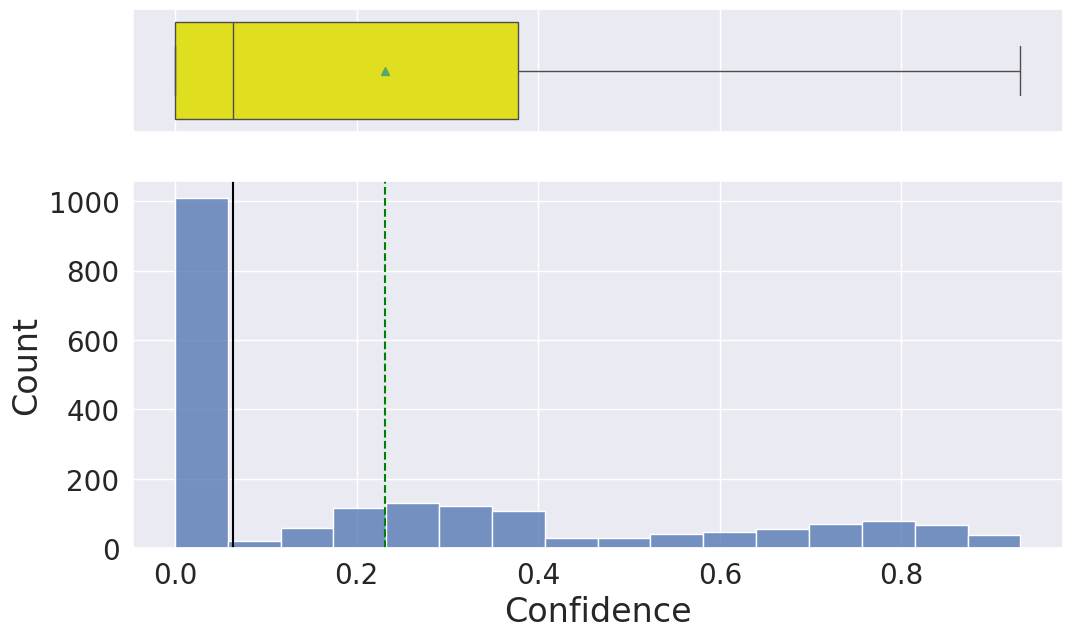

In [ ]:
# univariate analysis of Confidence
histogram_boxplot(df, 'Confidence')

**Confidence > 0.2 for categorization, > 0.7 for quantiative**

**Negative value issue has been resolved**

**There are 255 entries with confidence > 0.7, which is the same as the number for chemicals with AC10 values**

**There are 886 chemicals with Confidence > 0.2

As the data have been re-evaluated, simply use the Call_after_fit as labels. There is no need to assign labels using confidence values

There are also some well-known AhR agonists are also in 'Flag-Omit' group, such as fluoranthene and Benzo(k)fluoranthene**

## **Retrieve compound CID from its name using pubchempy**

### **Summary**

* 158 compounds in the training dataset can not retrieve CID from names.

*  The reason for errors is 'Not available and might not be a discrete structure,' or several entries will be retrieved.

*  For simplicity, these compounds are deleted from the list as most of them are mixtures or ill-defined structures. However, we may also lose some available structures, which is minor.








In [ ]:
import pubchempy as pcp

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8116 entries, 0 to 16230
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Compound            8116 non-null   object 
 1   CASRN               8116 non-null   object 
 2   Call                8116 non-null   object 
 3   EC50_concentration  540 non-null    float64
 4   Endpoint            8116 non-null   object 
 5   Is_viability        8116 non-null   bool   
 6   AC50_fit            466 non-null    float64
 7   Slope_fit           466 non-null    float64
 8   Top_fit             466 non-null    float64
 9   Bottom_fit          466 non-null    float64
 10  AC_10               466 non-null    float64
 11  Call_after_fit      8116 non-null   object 
 12  Confidence          2021 non-null   float64
 13  Plot_Nr             8116 non-null   object 
dtypes: bool(1), float64(7), object(6)
memory usage: 895.6+ KB


In [ ]:
#Compound = pd.DataFrame(df['Compound'].to_list(), columns = ['compound_name'])

In [ ]:
def search_pubchem(compound: str) -> int:
    """Search PubChem for a given compound and return its CID."""
    try:
        result = pcp.get_compounds(compound, 'name', record_type='2d')[0]
        return result.cid
    except (IndexError, pcp.PubChemHTTPError) as e:
        print(f"Error searching PubChem for {compound}: {e}")
        return None

In [ ]:
 # Loop through DataFrame and search PubChem for each compound
cids = []
for index, row in df.iterrows():
    compound_name = row['Compound']
    cid = search_pubchem(compound_name)
    cids.append(cid)
df['CID'] = cids

Error searching PubChem for (+-)-Bornyl acetate: list index out of range
Error searching PubChem for (+-)-Fluprostenol: list index out of range
Error searching PubChem for (+-)-cis-3-Methyl fentanyl hydrochloride: list index out of range
Error searching PubChem for (+-)-cis-3-Methyl thiofentanyl hydrochloride: list index out of range
Error searching PubChem for (11alpha)-16,16-Difluoro-11-hydroxy-9,15-dioxoprostan-1-oic acid: list index out of range
Error searching PubChem for (C10-C16) Alkylbenzenesulfonic acid: list index out of range
Error searching PubChem for (Methylcyclopentadienyl)tricarbonylmanganese: list index out of range
Error searching PubChem for (Methylthio)methylpyrazine: list index out of range
Error searching PubChem for (Tetrapropenyl)succinic anhydride: list index out of range
Error searching PubChem for 1, 2, 3- Benzenetricarboxylic acid, hydrate (1:x): list index out of range
Error searching PubChem for 1, 2- Benzenediol: list index out of range
Error searching Pu

*   The above chemicals are Ill- defined substance according to Chemical Dashboard




In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8116 entries, 0 to 16230
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Compound            8116 non-null   object 
 1   CASRN               8116 non-null   object 
 2   Call                8116 non-null   object 
 3   EC50_concentration  540 non-null    float64
 4   Endpoint            8116 non-null   object 
 5   Is_viability        8116 non-null   bool   
 6   AC50_fit            466 non-null    float64
 7   Slope_fit           466 non-null    float64
 8   Top_fit             466 non-null    float64
 9   Bottom_fit          466 non-null    float64
 10  AC_10               466 non-null    float64
 11  Call_after_fit      8116 non-null   object 
 12  Confidence          2021 non-null   float64
 13  Plot_Nr             8116 non-null   object 
 14  CID                 7958 non-null   float64
dtypes: bool(1), float64(8), object(6)
memory usage: 959.0+ KB


In [ ]:
df['CID'].isnull().sum()

158

In [ ]:
Null = df[df['CID'].isnull()]

In [ ]:
Null.info()

<class 'pandas.core.frame.DataFrame'>
Index: 158 entries, 42 to 16068
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Compound            158 non-null    object 
 1   CASRN               158 non-null    object 
 2   Call                158 non-null    object 
 3   EC50_concentration  11 non-null     float64
 4   Endpoint            158 non-null    object 
 5   Is_viability        158 non-null    bool   
 6   AC50_fit            13 non-null     float64
 7   Slope_fit           13 non-null     float64
 8   Top_fit             13 non-null     float64
 9   Bottom_fit          13 non-null     float64
 10  AC_10               13 non-null     float64
 11  Call_after_fit      158 non-null    object 
 12  Confidence          43 non-null     float64
 13  Plot_Nr             158 non-null    object 
 14  CID                 0 non-null      float64
dtypes: bool(1), float64(8), object(6)
memory usage: 18.7+ KB


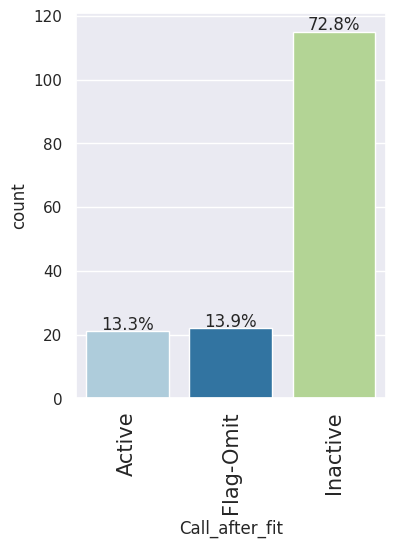

In [ ]:
labeled_barplot(Null,'Call_after_fit', perc = True)

In [ ]:
Null[Null['Call_after_fit'] == 'Active']

,Compound,CASRN,Call,EC50_concentration,Endpoint,Is_viability,AC50_fit,Slope_fit,Top_fit,Bottom_fit,AC_10,Call_after_fit,Confidence,Plot_Nr,CID
604,"1,2-Dihydro-2,2,4-trimethylquinoline, polymer",26780-96-1,QC-Omit,NaN,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Active,0.318,#605,NaN
1994,"2,4-Diaminoanisole sulfate hydrate (1:1:x)",123333-56-2,QC-Omit,NaN,TOX21_AhR_LUC_Agonist,False,1.330,1.372,155.005,0.000,0.483,Active,0.851,#1995,NaN
3230,"3,5,3'-Triiodo-L-thyronine monosodium salt",55-06-1,Active,9.021,TOX21_AhR_LUC_Agonist,False,0.962,1.466,55.338,0.000,0.514,Active,0.829,#3231,NaN
4816,Acriflavine hydrochloride,69235-50-3,Active,16.611,TOX21_AhR_LUC_Agonist,False,0.418,2.132,28.579,0.000,0.292,Active,0.731,#4817,NaN
6216,"C.I. Acid Yellow 11, sodium salt",6359-82-6,QC-Omit,NaN,TOX21_AhR_LUC_Agonist,False,1.438,0.717,122.569,0.000,-0.028,Active,0.712,#6217,NaN
6234,C.I. Basic Violet 1,8004-87-3,QC-Omit,NaN,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Active,0.288,#6235,NaN
6266,"C.I. Pigment Red 57, calcium salt (1:1)",4/9/5281,QC-Omit,NaN,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Active,0.225,#6267,NaN
6542,Casanthrol,8024-48-4,Active,37.791,TOX21_AhR_LUC_Agonist,False,1.536,1.160,78.622,0.000,0.815,Active,0.757,#6543,NaN
6784,Chlorophyllide Cu complex sodium salt,11006-34-1,QC-Omit,NaN,TOX21_AhR_LUC_Agonist,False,1.209,5.074,26.757,0.000,1.165,Active,0.922,#6785,NaN
6868,Chrysarobin,491-59-8,QC-Omit,NaN,TOX21_AhR_LUC_Agonist,False,0.725,1.282,46.326,0.000,0.288,Active,0.640,#6869,NaN


In [ ]:
##-------------------------------------------------------------------
## Save dataset with additional CID and export dataset for later use.
##-------------------------------------------------------------------


df.to_csv('20250311_Curated_dataset_with_CID.csv', index = False, header = True)

## **Retrieve parent CID & 3D sdf from PubChem**


### **Summary**

*   After several testing, CID from 2D information can't download 3D sdf file as it only represents parent compound or major component.

*   For mixtures, around 2000 entries, they need parent compound CID to download 3D sdf.

*   pubchempy can retrieve 3D SDF directly, but there are always errors on list index out of range.

*   For this purpose, we need to use PubChem Identifier Exchange Service.

*   https://pubchem.ncbi.nlm.nih.gov/idexchange/idexchange.cgi


In [ ]:
#load an csv file into a dataframe using Pandas after retrieving CID numbers
df = pd.read_csv('/content/drive/MyDrive/AhR/06/20250311_Curated_dataset_with_CID.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8116 entries, 0 to 8115
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Compound            8116 non-null   object 
 1   CASRN               8116 non-null   object 
 2   Call                8116 non-null   object 
 3   EC50_concentration  540 non-null    float64
 4   Endpoint            8116 non-null   object 
 5   Is_viability        8116 non-null   bool   
 6   AC50_fit            466 non-null    float64
 7   Slope_fit           466 non-null    float64
 8   Top_fit             466 non-null    float64
 9   Bottom_fit          466 non-null    float64
 10  AC_10               466 non-null    float64
 11  Call_after_fit      8116 non-null   object 
 12  Confidence          2021 non-null   float64
 13  Plot_Nr             8116 non-null   object 
 14  CID                 7958 non-null   float64
dtypes: bool(1), float64(8), object(6)
memory usage: 895.7+ 

In [ ]:
df_CID = pd.DataFrame(df['CID'].to_list(), columns=['CID'])

In [ ]:
df_CID.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8116 entries, 0 to 8115
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CID     7958 non-null   float64
dtypes: float64(1)
memory usage: 63.5 KB


In [ ]:
df_CID.isnull().sum()

,0
CID,158


In [ ]:
PubChem_CID_search_list = df_CID.dropna(subset = 'CID')
PubChem_CID_search_list = PubChem_CID_search_list['CID'].astype(int)

#PubChem_CID_search_list.to_csv('PubChem_CID_search_list.csv', index = False, header = False, sep='\t')


##-----------------------------------------------------------------------------------------------------------
## Use 'PubChem_CID_search_list' to retrieve parent chemical CID using PubChem Identifier Exchange ServiceUse
## 'Operator type' Select 'parent CID', 'Input' & 'Output' Select 'CIDs'
##-----------------------------------------------------------------------------------------------------------

In [ ]:
##-----------------------------------------------------------------------------------------------------------
## PubChem Identifier Exchange Service returns a text file
##-----------------------------------------------------------------------------------------------------------

CID_retrieved = pd.read_csv('/content/drive/MyDrive/AhR/06/Retrieved parent CID from CID.txt', sep='\t',names=['CID', 'parent CID'])
CID_retrieved.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7958 entries, 0 to 7957
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CID         7958 non-null   int64  
 1   parent CID  7723 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 124.5 KB


In [ ]:
CID_retrieved[CID_retrieved['parent CID'].isnull()]

##-----------------------------------------------------------------------------------------------------------
## 235 CIDs don't retrieve parent CIDs. Reasons are 'Conformer generation is disallowed since mixture or salt'
##-----------------------------------------------------------------------------------------------------------

,CID,parent CID
11,60196312,NaN
50,60196329,NaN
226,135482068,NaN
457,11344909,NaN
486,6442928,NaN
...,...,...
7731,9860484,NaN
7754,5727,NaN
7759,2724192,NaN
7763,159678,NaN


In [ ]:
CID_retrieved.duplicated(subset='parent CID', keep=False).sum()

np.int64(950)

In [ ]:
CID_retrieved.duplicated(subset='CID', keep=False).sum()

np.int64(56)

In [ ]:
##----------------------------
## create CID_unique dataframe
##----------------------------


CID_unique = CID_retrieved.dropna(subset='parent CID')

In [ ]:
CID_unique.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7723 entries, 0 to 7957
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CID         7723 non-null   int64  
 1   parent CID  7723 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 181.0 KB


In [ ]:
CID_unique = CID_unique.drop_duplicates(subset=['parent CID'], keep='first')

In [ ]:
CID_unique.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7306 entries, 0 to 7957
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CID         7306 non-null   int64  
 1   parent CID  7306 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 171.2 KB


In [ ]:
# Note the datatype of parent CID is float, but it needs to be integer in the PubChem search list.
CID_unique['parent CID'] = CID_unique['parent CID'].astype(int)

In [ ]:
CID_unique_parent = pd.DataFrame(CID_unique['parent CID'].to_list())
#CID_unique_parent.to_csv('CID_unique.csv', index = False, header = False, sep='\t')

##-----------------------------------------------------------------------------
## Use CID_unique to search chemicals in bulk from PubChem, then download 3D sdf
##-----------------------------------------------------------------------------

### **Import 3D sdf from PubChem**

In [ ]:
#load an SDF file into a dataframe using Pandas
frame = PandasTools.LoadSDF('/content/drive/MyDrive/AhR/06/3D_sdf.sdf')

[16:45:42] Warning: molecule is tagged as 3D, but all Z coords are zero and 2D stereo markers have been found, marking the mol as 2D.


In [ ]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6925 entries, 0 to 6924
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   PUBCHEM_COMPOUND_CID            6925 non-null   object
 1   PUBCHEM_CONFORMER_RMSD          6925 non-null   object
 2   PUBCHEM_CONFORMER_DIVERSEORDER  6925 non-null   object
 3   PUBCHEM_MMFF94_PARTIAL_CHARGES  6913 non-null   object
 4   PUBCHEM_EFFECTIVE_ROTOR_COUNT   6925 non-null   object
 5   PUBCHEM_PHARMACOPHORE_FEATURES  6925 non-null   object
 6   PUBCHEM_HEAVY_ATOM_COUNT        6925 non-null   object
 7   PUBCHEM_ATOM_DEF_STEREO_COUNT   6925 non-null   object
 8   PUBCHEM_ATOM_UDEF_STEREO_COUNT  6925 non-null   object
 9   PUBCHEM_BOND_DEF_STEREO_COUNT   6925 non-null   object
 10  PUBCHEM_BOND_UDEF_STEREO_COUNT  6925 non-null   object
 11  PUBCHEM_ISOTOPIC_ATOM_COUNT     6925 non-null   object
 12  PUBCHEM_COMPONENT_COUNT         6925 non-null   objec

In [ ]:
frame.duplicated(subset = ['PUBCHEM_COMPOUND_CID'], keep=False).sum()

0

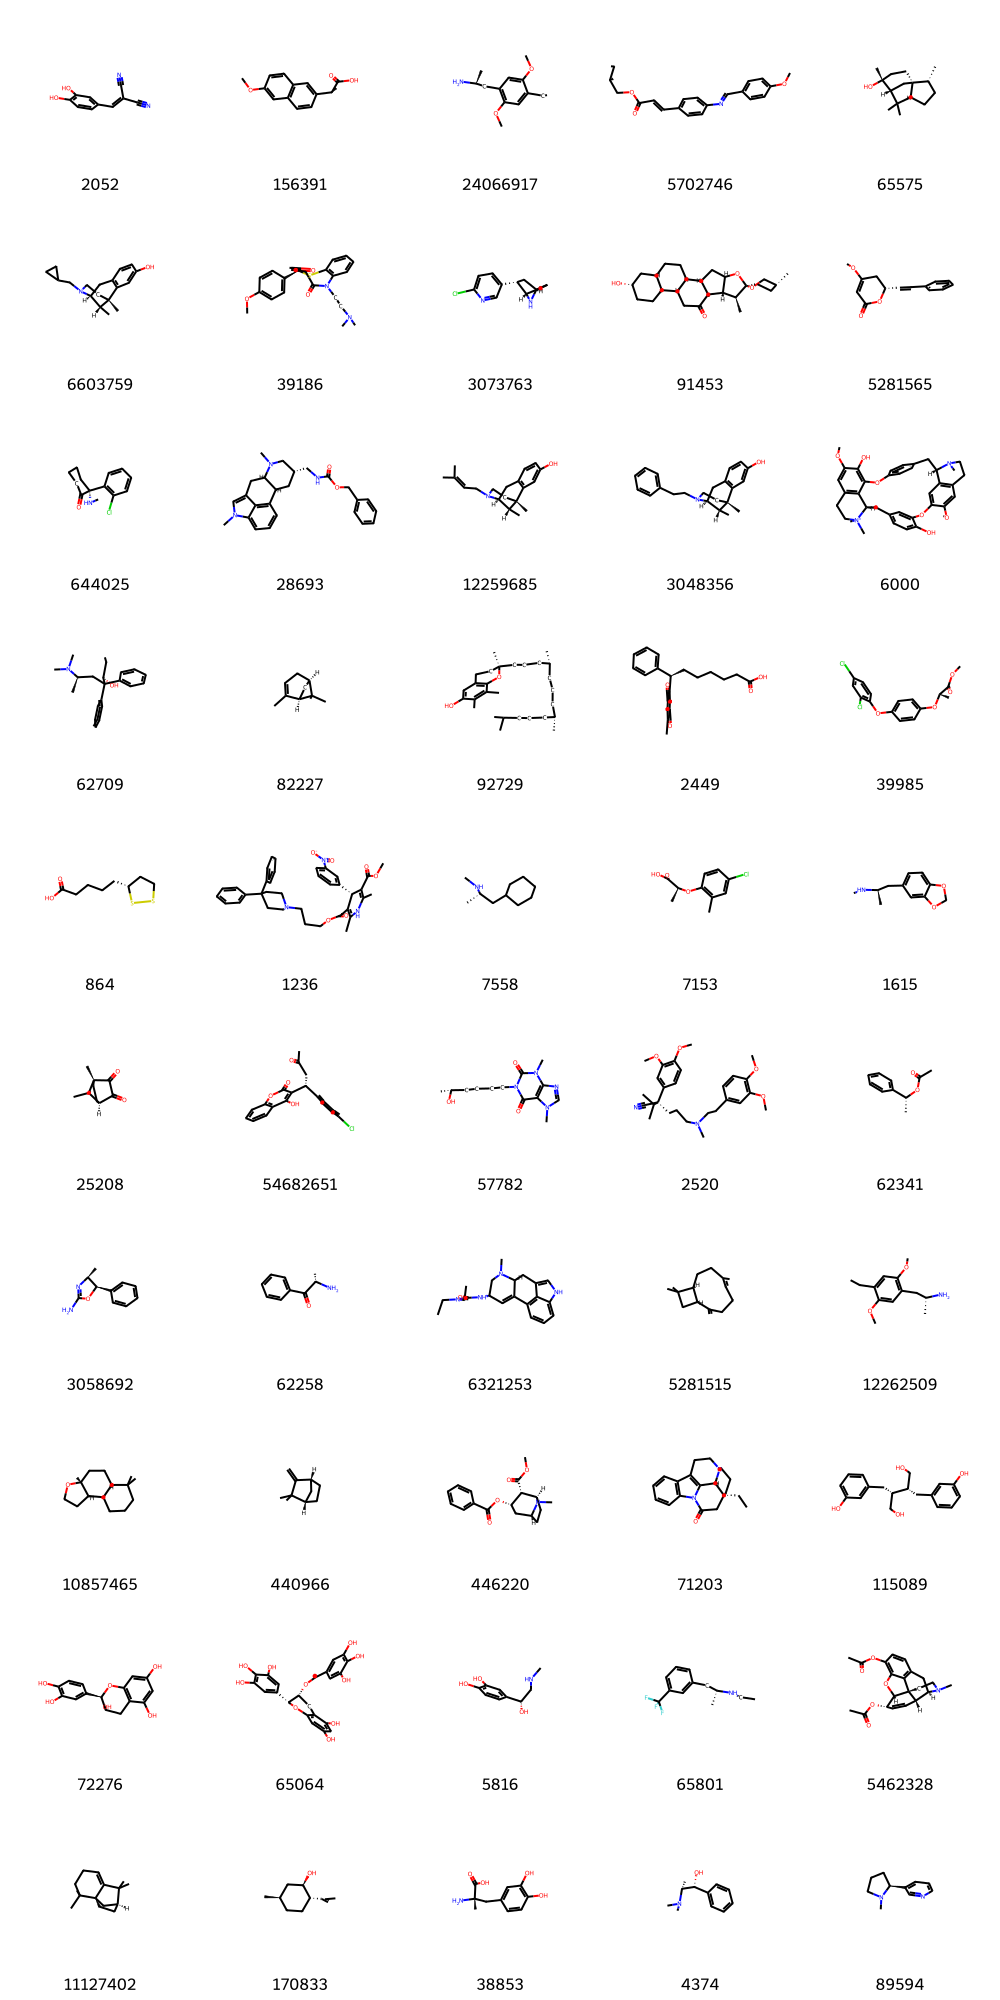

In [ ]:
# Draw the molecular structures in the dataframe
PandasTools.FrameToGridImage(frame, legendsCol="PUBCHEM_COMPOUND_CID", molsPerRow=5)

In [ ]:
COMPOUND_CID = frame["PUBCHEM_COMPOUND_CID"].tolist()
COMPOUND_CID = list(map(int, COMPOUND_CID))
len(COMPOUND_CID)

6925

In [ ]:
CID_whole = CID_unique['parent CID'].tolist()
len(CID_whole)

7306

In [ ]:
# Use filter to find elements in list1 not in list2
difference = list(filter(lambda x: x not in COMPOUND_CID, CID_whole))

In [ ]:
difference

[6438394,
 79050,
 7389,
 3032282,
 16683072,
 5364509,
 5311093,
 6327366,
 62630,
 6328651,
 18529,
 6787,
 14878,
 117734,
 2775941,
 12620,
 2734234,
 8221,
 7789,
 12942137,
 118379,
 7233,
 13132266,
 24762,
 21414,
 3681,
 82056,
 92667,
 162012,
 1730,
 12164,
 137994,
 5104,
 1985,
 6505,
 451415,
 457193,
 12629,
 2090,
 5493444,
 16682988,
 2131,
 14982,
 16682839,
 71884,
 5280965,
 16218600,
 85385138,
 644077,
 54680660,
 148192,
 5311010,
 47319,
 16132300,
 447043,
 31203,
 31205,
 7699,
 3740,
 9811353,
 67329,
 8345,
 31218,
 5365125,
 7642,
 22932,
 117291,
 7641,
 91555,
 16682746,
 60196425,
 8836,
 3034022,
 20055424,
 16683000,
 16682735,
 16683095,
 15284,
 108381,
 72467,
 387447,
 5280757,
 5354342,
 14236,
 133914,
 22961,
 5284350,
 6297,
 3315,
 6437494,
 8480,
 5287879,
 11556711,
 53315792,
 6708773,
 443382,
 656673,
 84029,
 16052039,
 6816,
 6713940,
 160339,
 24825758,
 5281233,
 5717190,
 93221,
 5284373,
 26198,
 2973,
 5966,
 28620,
 25077495,
 531

In [ ]:
len(difference)

##-----------------------------------------------------------------------------------------------------------
## 381 parent CIDs don't retrieve 3D sdf as no 3D conformers exist in the PubChem database due to vaired reasons.


381





## **Curate the retrieved parent CID and merge with raw dataset**






### **Summary**


*   From the very beginning, 8116 -- 7958 (with CIDs) -- 7929 (remove CID duplicates) -- 7723 (with parent CIDs) -- 7306 (remove parent CID duplicates) -- 6925 (with 3D sdf)

*   Append CIDs and comments to the raw dataset




In [ ]:
## reload curated dataset with CID
##------------------------------------------------------------------------------------
df = pd.read_csv('/content/drive/MyDrive/AhR/06/20250311_Curated_dataset_with_CID.csv')

## create a new dataframe removing null values in CID
##---------------------------------------------------

df_removed_null_CID = df.dropna(subset = ['CID'])

In [ ]:
## get the index for null values in CID and duplicates (without the first appearence) in CID
##-------------------------------------------------------------------------------------------

Duplicates_list = df_removed_null_CID[df_removed_null_CID.duplicated(subset = ['CID'], keep = 'first')].index.to_list()
Null_list = df[df['CID'].isnull()].index.to_list()

df['Flag_null_CID'] = df.index.isin(Null_list)
df['Flag_duplicate_CID'] = df.index.isin(Duplicates_list)

In [ ]:
df_removed_null_CID[df_removed_null_CID.duplicated(subset = ['CID'], keep = 'first')]
## There are 56 duplicates in total in CID

,Compound,CASRN,Call,EC50_concentration,Endpoint,Is_viability,AC50_fit,Slope_fit,Top_fit,Bottom_fit,AC_10,Call_after_fit,Confidence,Plot_Nr,CID
417,"1,4-Dichloro-2-butene",764-41-0,QC-Omit,NaN,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Inactive,NaN,#835,642197.000
957,"2,4,4-Trimethylpentene",25167-70-8,QC-Omit,NaN,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Inactive,NaN,#1915,7868.000
1824,3-Phenylprop-2-enal,104-55-2,Inactive,NaN,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Flag-Omit,0.000,#3649,637511.000
2065,4-Hydroxytamoxifen,68392-35-8,Inactive,NaN,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Inactive,NaN,#4131,449459.000
2491,Aloin A,1415-73-2,QC-Omit,NaN,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Inactive,NaN,#4983,12305761.000
2594,Anethole,104-46-1,QC-Omit,NaN,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Inactive,NaN,#5189,637563.000
4008,Dihydromyrcenol,53219-21-9,Inactive,NaN,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Inactive,NaN,#8017,29096.000
4074,"Dimethyl trans-cyclohexane-1,4-dicarboxylate",3399-22-2,Inactive,NaN,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Inactive,NaN,#8149,7198.000
4818,Glyceryl monooctanoate,26402-26-6,Inactive,NaN,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Inactive,NaN,#9637,3033877.000
4821,Glyceryl stearate,11099-07-3,QC-Omit,NaN,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Inactive,NaN,#9643,24699.000


In [ ]:
df.tail(50)

,Compound,CASRN,Call,EC50_concentration,Endpoint,Is_viability,AC50_fit,Slope_fit,Top_fit,Bottom_fit,AC_10,Call_after_fit,Confidence,Plot_Nr,CID,Comment
8066,p-Tolylurea,622-51-5,Inactive,NaN,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Inactive,NaN,#16133,12148.000,False
8067,p-Xylene,106-42-3,QC-Omit,NaN,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Inactive,NaN,#16135,7809.000,False
8068,p-Xylenol blue,125-31-5,QC-Omit,NaN,TOX21_AhR_LUC_Agonist,False,1.269,2.184,44.817,0.000,1.021,Active,0.832,#16137,67172.000,False
8069,para-Fluorofentanyl,90736-23-5,Inactive,NaN,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Inactive,NaN,#16139,62300.000,False
8070,rac Benidipine hydrochloride,91599-74-5,Inactive,NaN,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Flag-Omit,0.000,#16141,656667.000,False
8071,rac Nebivolol hydrochloride,169293-50-9,Inactive,NaN,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Inactive,NaN,#16143,9933004.000,False
8072,"rel-(1R,4S,4aS,5R,8S,8aR)-1,2,3,4,10,10-Hexach...",465-73-6,Inactive,NaN,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Inactive,NaN,#16145,12310946.000,False
8073,"rel-(1S,5S)-3,3,5-Trimethylcyclohexanol",933-48-2,QC-Omit,NaN,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Inactive,NaN,#16147,101921.000,False
8074,"rel-(2R,4aR,8aR)-Hexahydro-1,1,5,5-tetramethyl...",29461-14-1,QC-Omit,NaN,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Inactive,NaN,#16149,11287462.000,False
8075,"rel-(2R,5R)-5-Methyl-2-(1-methylethyl)cyclohex...",491-07-6,QC-Omit,NaN,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Inactive,NaN,#16151,70962.000,False


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8116 entries, 0 to 8115
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Compound            8116 non-null   object 
 1   CASRN               8116 non-null   object 
 2   Call                8116 non-null   object 
 3   EC50_concentration  540 non-null    float64
 4   Endpoint            8116 non-null   object 
 5   Is_viability        8116 non-null   bool   
 6   AC50_fit            466 non-null    float64
 7   Slope_fit           466 non-null    float64
 8   Top_fit             466 non-null    float64
 9   Bottom_fit          466 non-null    float64
 10  AC_10               466 non-null    float64
 11  Call_after_fit      8116 non-null   object 
 12  Confidence          2021 non-null   float64
 13  Plot_Nr             8116 non-null   object 
 14  CID                 7958 non-null   float64
 15  Flag_null_CID       8116 non-null   bool   
 16  Flag_d

In [ ]:
df_removed_null_CID.duplicated(subset = ['CID'], keep = False).sum()

##------------------------------------------------------------------------------------------------
## There are 56 duplicates in total. Two or more chemicals with different CASRN share the same CID.

np.int64(56)

In [ ]:
df_removed_null_CID[df_removed_null_CID['CID'] == 727]

,Compound,CASRN,Call,EC50_concentration,Endpoint,Is_viability,AC50_fit,Slope_fit,Top_fit,Bottom_fit,AC_10,Call_after_fit,Confidence,Plot_Nr,CID
250,"1,2,3,4,5,6-Hexachlorocyclohexane",608-73-1,QC-Omit,NaN,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Inactive,NaN,#501,727.000
5333,Lindane,58-89-9,Inactive,NaN,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Inactive,NaN,#10667,727.000
7941,"alpha-1,2,3,4,5,6-Hexachlorocyclohexane",319-84-6,Inactive,NaN,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Inactive,NaN,#15883,727.000
7982,beta-Hexachlorocyclohexane,319-85-7,QC-Omit,NaN,TOX21_AhR_LUC_Agonist,False,NaN,NaN,NaN,NaN,NaN,Inactive,NaN,#15965,727.000


In [ ]:
##---------------------------------------------------------------------
## create DF to have unique CID

DF = df_removed_null_CID.drop_duplicates(subset=['CID'], keep = 'first')

In [ ]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7929 entries, 0 to 8115
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Compound            7929 non-null   object 
 1   CASRN               7929 non-null   object 
 2   Call                7929 non-null   object 
 3   EC50_concentration  529 non-null    float64
 4   Endpoint            7929 non-null   object 
 5   Is_viability        7929 non-null   bool   
 6   AC50_fit            452 non-null    float64
 7   Slope_fit           452 non-null    float64
 8   Top_fit             452 non-null    float64
 9   Bottom_fit          452 non-null    float64
 10  AC_10               452 non-null    float64
 11  Call_after_fit      7929 non-null   object 
 12  Confidence          1975 non-null   float64
 13  Plot_Nr             7929 non-null   object 
 14  CID                 7929 non-null   float64
dtypes: bool(1), float64(8), object(6)
memory usage: 936.9+ KB


In [ ]:
##---------------------------------------------------------------------
## upload text file and also keep unique CID

CID = pd.read_csv('/content/drive/MyDrive/AhR/06/Retrieved parent CID from CID.txt', sep='\t',names=['CID', 'parent CID'])
CID.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7958 entries, 0 to 7957
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CID         7958 non-null   int64  
 1   parent CID  7723 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 124.5 KB


In [ ]:
CID = CID.drop_duplicates(subset = ['CID'], keep = 'first')
CID.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7929 entries, 0 to 7957
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CID         7929 non-null   int64  
 1   parent CID  7694 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 185.8 KB


In [ ]:
CID[CID['parent CID'].isnull()]

,CID,parent CID
11,60196312,NaN
50,60196329,NaN
226,135482068,NaN
457,11344909,NaN
486,6442928,NaN
...,...,...
7731,9860484,NaN
7754,5727,NaN
7759,2724192,NaN
7763,159678,NaN


In [ ]:
##------------------------------------------
## merge two dataset with unique CID

df_parent_CID = pd.merge(DF, CID,how='inner',on='CID')

In [ ]:
df_parent_CID.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7929 entries, 0 to 7928
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Compound            7929 non-null   object 
 1   CASRN               7929 non-null   object 
 2   Call                7929 non-null   object 
 3   EC50_concentration  529 non-null    float64
 4   Endpoint            7929 non-null   object 
 5   Is_viability        7929 non-null   bool   
 6   AC50_fit            452 non-null    float64
 7   Slope_fit           452 non-null    float64
 8   Top_fit             452 non-null    float64
 9   Bottom_fit          452 non-null    float64
 10  AC_10               452 non-null    float64
 11  Call_after_fit      7929 non-null   object 
 12  Confidence          1975 non-null   float64
 13  Plot_Nr             7929 non-null   object 
 14  CID                 7929 non-null   float64
 15  parent CID          7694 non-null   float64
dtypes: boo

In [ ]:
df_parent_CID1 = df_parent_CID.dropna(subset = ['parent CID'])
df_parent_CID1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7694 entries, 0 to 7928
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Compound            7694 non-null   object 
 1   CASRN               7694 non-null   object 
 2   Call                7694 non-null   object 
 3   EC50_concentration  526 non-null    float64
 4   Endpoint            7694 non-null   object 
 5   Is_viability        7694 non-null   bool   
 6   AC50_fit            449 non-null    float64
 7   Slope_fit           449 non-null    float64
 8   Top_fit             449 non-null    float64
 9   Bottom_fit          449 non-null    float64
 10  AC_10               449 non-null    float64
 11  Call_after_fit      7694 non-null   object 
 12  Confidence          1941 non-null   float64
 13  Plot_Nr             7694 non-null   object 
 14  CID                 7694 non-null   float64
 15  parent CID          7694 non-null   float64
dtypes: bool(1),

In [ ]:
df_parent_CID1.duplicated(subset = ['parent CID'], keep = 'first').sum()

np.int64(388)

In [ ]:
## Both lists are specific to CID numbers
CID['CID'] = CID['CID'].astype(float)
parent_CID_null_list = CID['CID'][CID['parent CID'].isnull()].to_list()
parent_CID_duplicate_list = df_parent_CID1['CID'][df_parent_CID1.duplicated(subset = ['parent CID'], keep = 'first')].tolist()

In [ ]:
print(parent_CID_duplicate_list)

[2723715.0, 11990.0, 10941.0, 12184311.0, 60196384.0, 11048104.0, 11769095.0, 16213711.0, 11076461.0, 12195864.0, 11212667.0, 2734167.0, 11832800.0, 2734250.0, 21988023.0, 15932798.0, 60196390.0, 11258643.0, 2734161.0, 11171745.0, 11448496.0, 11424151.0, 2734246.0, 19876500.0, 45268380.0, 23079882.0, 11074101.0, 11995188.0, 60196392.0, 14007922.0, 2734248.0, 12040509.0, 2734225.0, 11461044.0, 22239085.0, 53316407.0, 2734227.0, 10250129.0, 16211417.0, 46226173.0, 23160059.0, 53316417.0, 12059921.0, 60196393.0, 21932259.0, 16210995.0, 11731903.0, 11075478.0, 16211849.0, 16211115.0, 2758874.0, 2734235.0, 12038941.0, 13638937.0, 60196375.0, 50878565.0, 18506491.0, 10411334.0, 2734163.0, 12036651.0, 2734179.0, 2734172.0, 21917397.0, 2734181.0, 2734249.0, 16726630.0, 60196387.0, 25171607.0, 60196394.0, 12059922.0, 60196396.0, 12184591.0, 2734223.0, 11460221.0, 16212746.0, 12040508.0, 12971008.0, 60196379.0, 60196381.0, 9257.0, 23662264.0, 23676704.0, 1486.0, 1489.0, 5284385.0, 88898.0, 23665

In [ ]:
# Loop through DataFrame to make a flag
Flag = []
for index, row in df_parent_CID.iterrows():
    if row['CID'] in parent_CID_null_list:
      comment = f"No conformers in PubChem due to varied reasons"
      Flag.append(comment)
    elif row['CID'] in parent_CID_duplicate_list:
      comment = f"Removed duplicates"
      Flag.append(comment)
    else:
      comment = None
      Flag.append(comment)

df_parent_CID['Flag_parent_CID'] = Flag

In [ ]:
df_parent_CID.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7929 entries, 0 to 7928
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Compound            7929 non-null   object 
 1   CASRN               7929 non-null   object 
 2   Call                7929 non-null   object 
 3   EC50_concentration  529 non-null    float64
 4   Endpoint            7929 non-null   object 
 5   Is_viability        7929 non-null   bool   
 6   AC50_fit            452 non-null    float64
 7   Slope_fit           452 non-null    float64
 8   Top_fit             452 non-null    float64
 9   Bottom_fit          452 non-null    float64
 10  AC_10               452 non-null    float64
 11  Call_after_fit      7929 non-null   object 
 12  Confidence          1975 non-null   float64
 13  Plot_Nr             7929 non-null   object 
 14  CID                 7929 non-null   float64
 15  parent CID          7694 non-null   float64
 16  Flag_p

In [ ]:
## There are 388 (without first appearence) duplicates in the parent CID.
## This makes sense as the major components might be the same for some mixtures or salts
##---------------------------------------------------------------------------------------

df_parent_CID2 = df_parent_CID1.drop_duplicates(subset = ['parent CID'], keep = 'first')
df_parent_CID2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7306 entries, 0 to 7928
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Compound            7306 non-null   object 
 1   CASRN               7306 non-null   object 
 2   Call                7306 non-null   object 
 3   EC50_concentration  505 non-null    float64
 4   Endpoint            7306 non-null   object 
 5   Is_viability        7306 non-null   bool   
 6   AC50_fit            428 non-null    float64
 7   Slope_fit           428 non-null    float64
 8   Top_fit             428 non-null    float64
 9   Bottom_fit          428 non-null    float64
 10  AC_10               428 non-null    float64
 11  Call_after_fit      7306 non-null   object 
 12  Confidence          1866 non-null   float64
 13  Plot_Nr             7306 non-null   object 
 14  CID                 7306 non-null   float64
 15  parent CID          7306 non-null   float64
dtypes: bool(1),

In [ ]:
##--------------------------------------------------------------------------------------------------
## make a comment for parent CID to provide the difference between retrieved 3d SDF and no retrieved

unique = pd.DataFrame(difference, columns=['CID'])
COMPOUND_CID = pd.DataFrame(COMPOUND_CID, columns=['CID'])
#unique.to_csv('unique.csv', index = False, header = False, sep='\t')

unique['CID'] = unique['CID'].astype(float)
COMPOUND_CID['CID'] = COMPOUND_CID['CID'].astype(float)

 # Loop through DataFrame to make a flag
comments = []
for index, row in df_parent_CID2.iterrows():
    if row['parent CID'] in unique['CID'].values:
      #print(f"Conformer generation is disallowed since too flexible.")
      comment = f"Conformer generation is disallowed since too flexible."
      comments.append(comment)
    elif row['parent CID'] in COMPOUND_CID['CID'].values:
      comment = f"3D sdf retrieved."
      comments.append(comment)
    else:
      comment = None
      comments.append(comment)

df_parent_CID2['Comments'] = comments

In [ ]:
df_parent_CID2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7306 entries, 0 to 7928
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Compound            7306 non-null   object 
 1   CASRN               7306 non-null   object 
 2   Call                7306 non-null   object 
 3   EC50_concentration  505 non-null    float64
 4   Endpoint            7306 non-null   object 
 5   Is_viability        7306 non-null   bool   
 6   AC50_fit            428 non-null    float64
 7   Slope_fit           428 non-null    float64
 8   Top_fit             428 non-null    float64
 9   Bottom_fit          428 non-null    float64
 10  AC_10               428 non-null    float64
 11  Call_after_fit      7306 non-null   object 
 12  Confidence          1866 non-null   float64
 13  Plot_Nr             7306 non-null   object 
 14  CID                 7306 non-null   float64
 15  parent CID          7306 non-null   float64
 16  Comments   

In [ ]:
df_parent_CID.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7929 entries, 0 to 7928
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Compound            7929 non-null   object 
 1   CASRN               7929 non-null   object 
 2   Call                7929 non-null   object 
 3   EC50_concentration  529 non-null    float64
 4   Endpoint            7929 non-null   object 
 5   Is_viability        7929 non-null   bool   
 6   AC50_fit            452 non-null    float64
 7   Slope_fit           452 non-null    float64
 8   Top_fit             452 non-null    float64
 9   Bottom_fit          452 non-null    float64
 10  AC_10               452 non-null    float64
 11  Call_after_fit      7929 non-null   object 
 12  Confidence          1975 non-null   float64
 13  Plot_Nr             7929 non-null   object 
 14  CID                 7929 non-null   float64
 15  parent CID          7694 non-null   float64
 16  Flag_p

In [ ]:
##------------------------------------------------------
## First merge df_parent_CID2 and df_parent_CID
##------------------------------------------------------

Retain_column = ['CASRN', 'Comments']
df_parent_CID_for_merge1 = df_parent_CID2[Retain_column]

In [ ]:
Merge1 = pd.merge(df_parent_CID, df_parent_CID_for_merge1, how='outer', on='CASRN')

In [ ]:
Merge1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7929 entries, 0 to 7928
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Compound            7929 non-null   object 
 1   CASRN               7929 non-null   object 
 2   Call                7929 non-null   object 
 3   EC50_concentration  529 non-null    float64
 4   Endpoint            7929 non-null   object 
 5   Is_viability        7929 non-null   bool   
 6   AC50_fit            452 non-null    float64
 7   Slope_fit           452 non-null    float64
 8   Top_fit             452 non-null    float64
 9   Bottom_fit          452 non-null    float64
 10  AC_10               452 non-null    float64
 11  Call_after_fit      7929 non-null   object 
 12  Confidence          1975 non-null   float64
 13  Plot_Nr             7929 non-null   object 
 14  CID                 7929 non-null   float64
 15  parent CID          7694 non-null   float64
 16  Flag_p

In [ ]:
##---------------------------------------------------------------------
##Second merge 'merger1' and 'df'

Retain_column2 = ['CASRN', 'parent CID', 'Flag_parent_CID', 'Comments']
Merge2 = Merge1[Retain_column2]

In [ ]:
Merge2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7929 entries, 0 to 7928
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CASRN            7929 non-null   object 
 1   parent CID       7694 non-null   float64
 2   Flag_parent_CID  623 non-null    object 
 3   Comments         7306 non-null   object 
dtypes: float64(1), object(3)
memory usage: 247.9+ KB


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8116 entries, 0 to 8115
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Compound            8116 non-null   object 
 1   CASRN               8116 non-null   object 
 2   Call                8116 non-null   object 
 3   EC50_concentration  540 non-null    float64
 4   Endpoint            8116 non-null   object 
 5   Is_viability        8116 non-null   bool   
 6   AC50_fit            466 non-null    float64
 7   Slope_fit           466 non-null    float64
 8   Top_fit             466 non-null    float64
 9   Bottom_fit          466 non-null    float64
 10  AC_10               466 non-null    float64
 11  Call_after_fit      8116 non-null   object 
 12  Confidence          2021 non-null   float64
 13  Plot_Nr             8116 non-null   object 
 14  CID                 7958 non-null   float64
 15  Flag_null_CID       8116 non-null   bool   
 16  Flag_d

In [ ]:
Curated_dataset_with_flags = pd.merge(df, Merge2, how='outer', on='CASRN')
Curated_dataset_with_flags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8116 entries, 0 to 8115
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Compound            8116 non-null   object 
 1   CASRN               8116 non-null   object 
 2   Call                8116 non-null   object 
 3   EC50_concentration  540 non-null    float64
 4   Endpoint            8116 non-null   object 
 5   Is_viability        8116 non-null   bool   
 6   AC50_fit            466 non-null    float64
 7   Slope_fit           466 non-null    float64
 8   Top_fit             466 non-null    float64
 9   Bottom_fit          466 non-null    float64
 10  AC_10               466 non-null    float64
 11  Call_after_fit      8116 non-null   object 
 12  Confidence          2021 non-null   float64
 13  Plot_Nr             8116 non-null   object 
 14  CID                 7958 non-null   float64
 15  Flag_null_CID       8116 non-null   bool   
 16  Flag_d

In [ ]:
##-----------------------------------------------------------------------------------------
## Done curating the very raw data with flags

##Curated_dataset_with_flags.to_csv('20250312_Curated_dataset_with_flags.csv', index = False)

## **Split data into training datasets with different purposes**

In [ ]:
#load an SDF file into a dataframe using Pandas
frame = PandasTools.LoadSDF('/content/drive/MyDrive/AhR/06/3D_sdf.sdf')

#Calculate the exact mass of each molcular and append the list, this calculates the exact mass of detached structure, especially for salts and mixtures in the list
frame['MW'] = [Chem.rdMolDescriptors.CalcExactMolWt(x) for x in frame['ROMol']]
#Calculate LogP of each molcular and append the list to df
frame['LogP'] = [Chem.Crippen.MolLogP(x) for x in frame['ROMol']]

frame["PUBCHEM_COMPOUND_CID"] = frame["PUBCHEM_COMPOUND_CID"].astype(float)
df_parent_CID3 = df_parent_CID2.rename(columns={"parent CID": "PUBCHEM_COMPOUND_CID"})

frame = pd.merge(frame, df_parent_CID3, how='inner', on='PUBCHEM_COMPOUND_CID')

[16:48:13] Warning: molecule is tagged as 3D, but all Z coords are zero and 2D stereo markers have been found, marking the mol as 2D.


In [ ]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6925 entries, 0 to 6924
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   PUBCHEM_COMPOUND_CID            6925 non-null   float64
 1   PUBCHEM_CONFORMER_RMSD          6925 non-null   object 
 2   PUBCHEM_CONFORMER_DIVERSEORDER  6925 non-null   object 
 3   PUBCHEM_MMFF94_PARTIAL_CHARGES  6913 non-null   object 
 4   PUBCHEM_EFFECTIVE_ROTOR_COUNT   6925 non-null   object 
 5   PUBCHEM_PHARMACOPHORE_FEATURES  6925 non-null   object 
 6   PUBCHEM_HEAVY_ATOM_COUNT        6925 non-null   object 
 7   PUBCHEM_ATOM_DEF_STEREO_COUNT   6925 non-null   object 
 8   PUBCHEM_ATOM_UDEF_STEREO_COUNT  6925 non-null   object 
 9   PUBCHEM_BOND_DEF_STEREO_COUNT   6925 non-null   object 
 10  PUBCHEM_BOND_UDEF_STEREO_COUNT  6925 non-null   object 
 11  PUBCHEM_ISOTOPIC_ATOM_COUNT     6925 non-null   object 
 12  PUBCHEM_COMPONENT_COUNT         69

In [ ]:
##------------------------------------------------------------------------------------------------
##Filter MW from 50 to 800, and LogP from -2-8, which are both based on parent compound structures
##------------------------------------------------------------------------------------------------

frame_filter = frame[(frame['MW'] >= 50) & (frame['MW'] <= 800)]
frame_filter = frame_filter[(frame_filter['LogP'] >= -2) & (frame_filter['LogP'] <= 8)]

In [ ]:
frame_filter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6766 entries, 0 to 6924
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   PUBCHEM_COMPOUND_CID            6766 non-null   float64
 1   PUBCHEM_CONFORMER_RMSD          6766 non-null   object 
 2   PUBCHEM_CONFORMER_DIVERSEORDER  6766 non-null   object 
 3   PUBCHEM_MMFF94_PARTIAL_CHARGES  6754 non-null   object 
 4   PUBCHEM_EFFECTIVE_ROTOR_COUNT   6766 non-null   object 
 5   PUBCHEM_PHARMACOPHORE_FEATURES  6766 non-null   object 
 6   PUBCHEM_HEAVY_ATOM_COUNT        6766 non-null   object 
 7   PUBCHEM_ATOM_DEF_STEREO_COUNT   6766 non-null   object 
 8   PUBCHEM_ATOM_UDEF_STEREO_COUNT  6766 non-null   object 
 9   PUBCHEM_BOND_DEF_STEREO_COUNT   6766 non-null   object 
 10  PUBCHEM_BOND_UDEF_STEREO_COUNT  6766 non-null   object 
 11  PUBCHEM_ISOTOPIC_ATOM_COUNT     6766 non-null   object 
 12  PUBCHEM_COMPONENT_COUNT         6766 no

In [ ]:
frame_filter['Call_after_fit'].value_counts()

,count
Call_after_fit,
Inactive,4946
Flag-Omit,1025
Active,795




*   After a filter by MW and LogKow,there are 795 AhR agonists and 4946 non-active agonists.
*   The trainning dataset is imbalanced with a ratio up to approx. 1:6






In [ ]:
# Extract trainning dateset with labels as Active and Inactive
Training_dataset = frame_filter.drop(frame_filter[frame_filter['Call_after_fit'] == 'Flag-Omit'].index)
In_house_test_dataset = frame_filter[frame_filter['Call_after_fit'] == 'Flag-Omit']
Training_dataset_regression = frame_filter[frame_filter['Confidence'] >= 0.7]

In [ ]:
#Training_dataset.to_csv("Training_dataset_classification.csv",index = False, header = True)
In_house_test_dataset.to_csv("In_house_test_dataset.csv",index = False, header = True)
Training_dataset_regression.to_csv("Training_dataset_regression.csv",index = False, header = True)

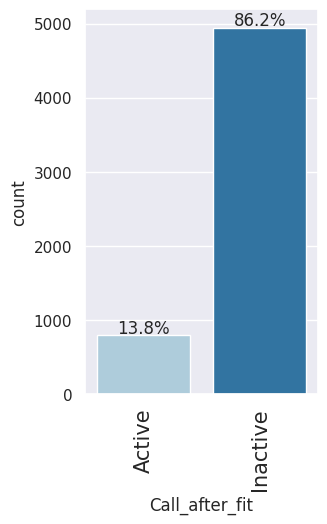

In [ ]:
labeled_barplot(Training_dataset, "Call_after_fit", perc = True)

In [ ]:
Active = Training_dataset[Training_dataset["Call_after_fit"] == "Active"]
Inactive = Training_dataset[Training_dataset["Call_after_fit"] == "Inactive"]

In [ ]:
Active.info()

<class 'pandas.core.frame.DataFrame'>
Index: 795 entries, 3 to 6910
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   PUBCHEM_COMPOUND_CID            795 non-null    float64
 1   PUBCHEM_CONFORMER_RMSD          795 non-null    object 
 2   PUBCHEM_CONFORMER_DIVERSEORDER  795 non-null    object 
 3   PUBCHEM_MMFF94_PARTIAL_CHARGES  794 non-null    object 
 4   PUBCHEM_EFFECTIVE_ROTOR_COUNT   795 non-null    object 
 5   PUBCHEM_PHARMACOPHORE_FEATURES  795 non-null    object 
 6   PUBCHEM_HEAVY_ATOM_COUNT        795 non-null    object 
 7   PUBCHEM_ATOM_DEF_STEREO_COUNT   795 non-null    object 
 8   PUBCHEM_ATOM_UDEF_STEREO_COUNT  795 non-null    object 
 9   PUBCHEM_BOND_DEF_STEREO_COUNT   795 non-null    object 
 10  PUBCHEM_BOND_UDEF_STEREO_COUNT  795 non-null    object 
 11  PUBCHEM_ISOTOPIC_ATOM_COUNT     795 non-null    object 
 12  PUBCHEM_COMPONENT_COUNT         795 non-

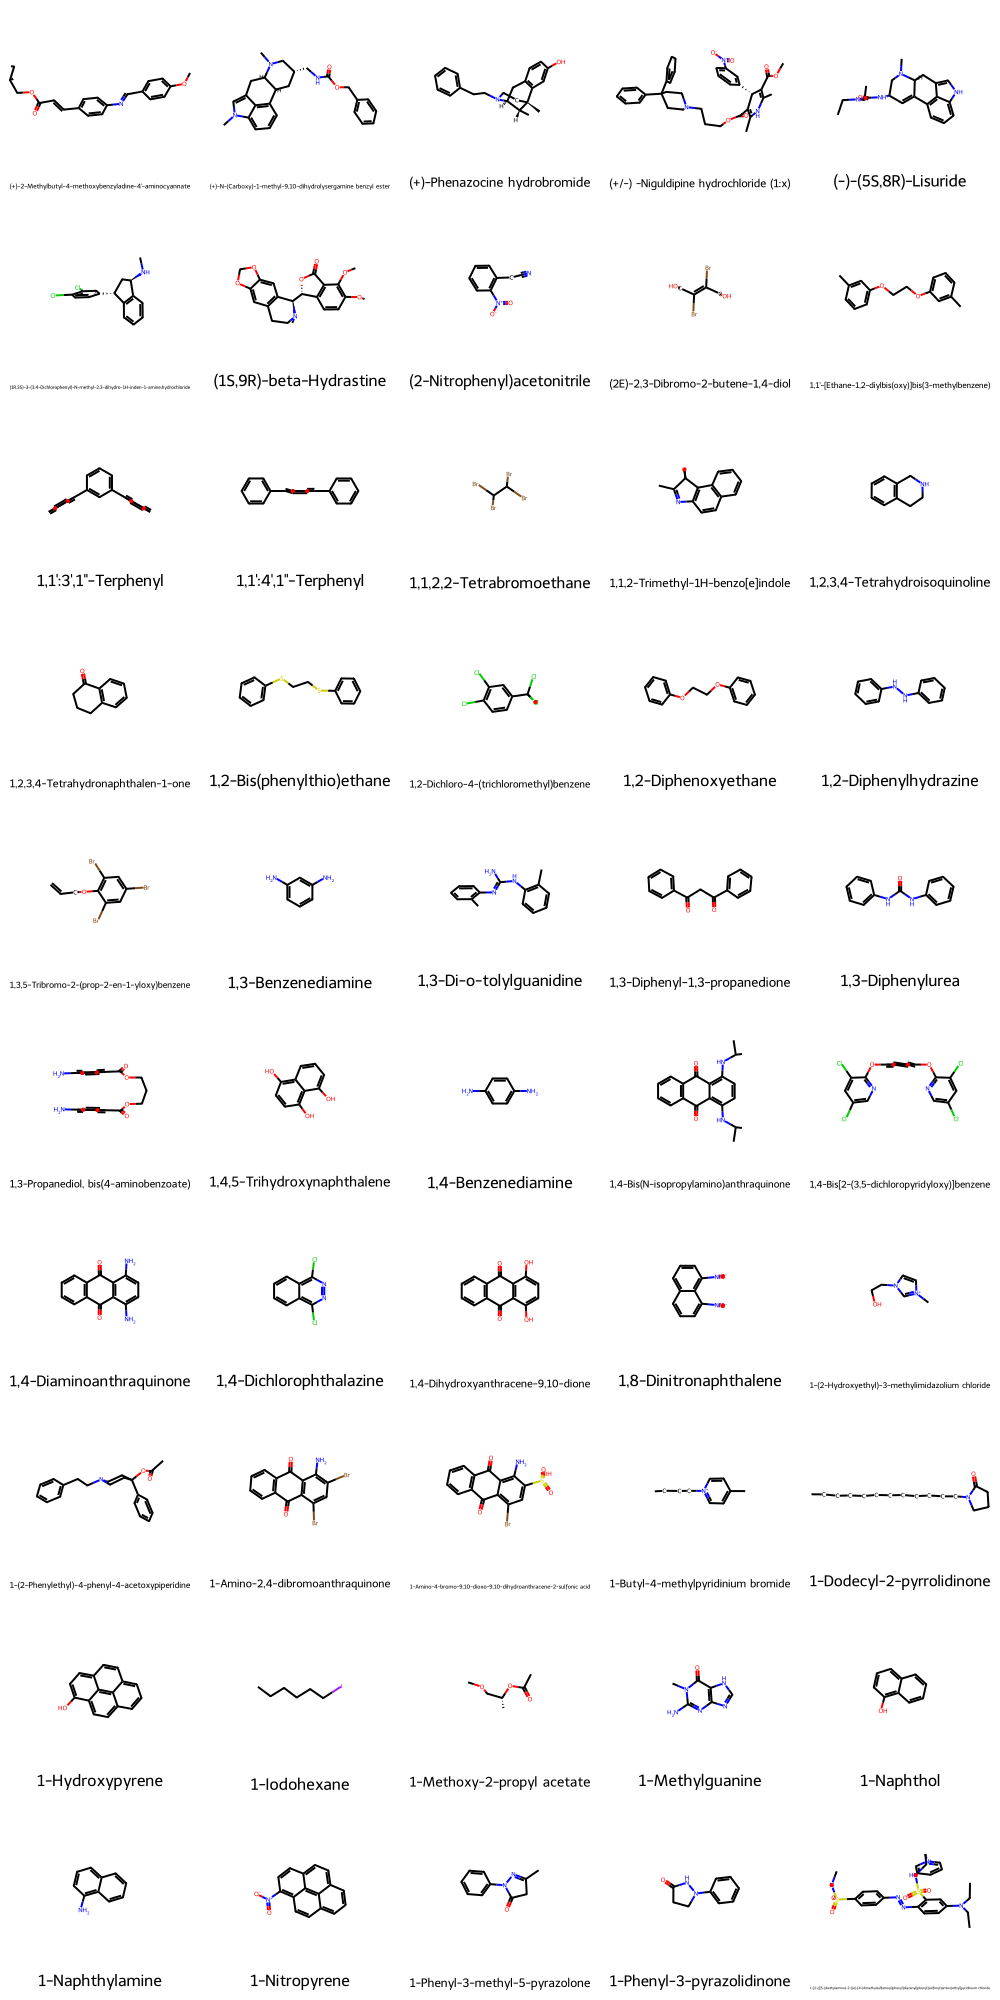

In [ ]:
# Draw the molecular structures in the dataframe
PandasTools.FrameToGridImage(Active, legendsCol="Compound", molsPerRow=5)

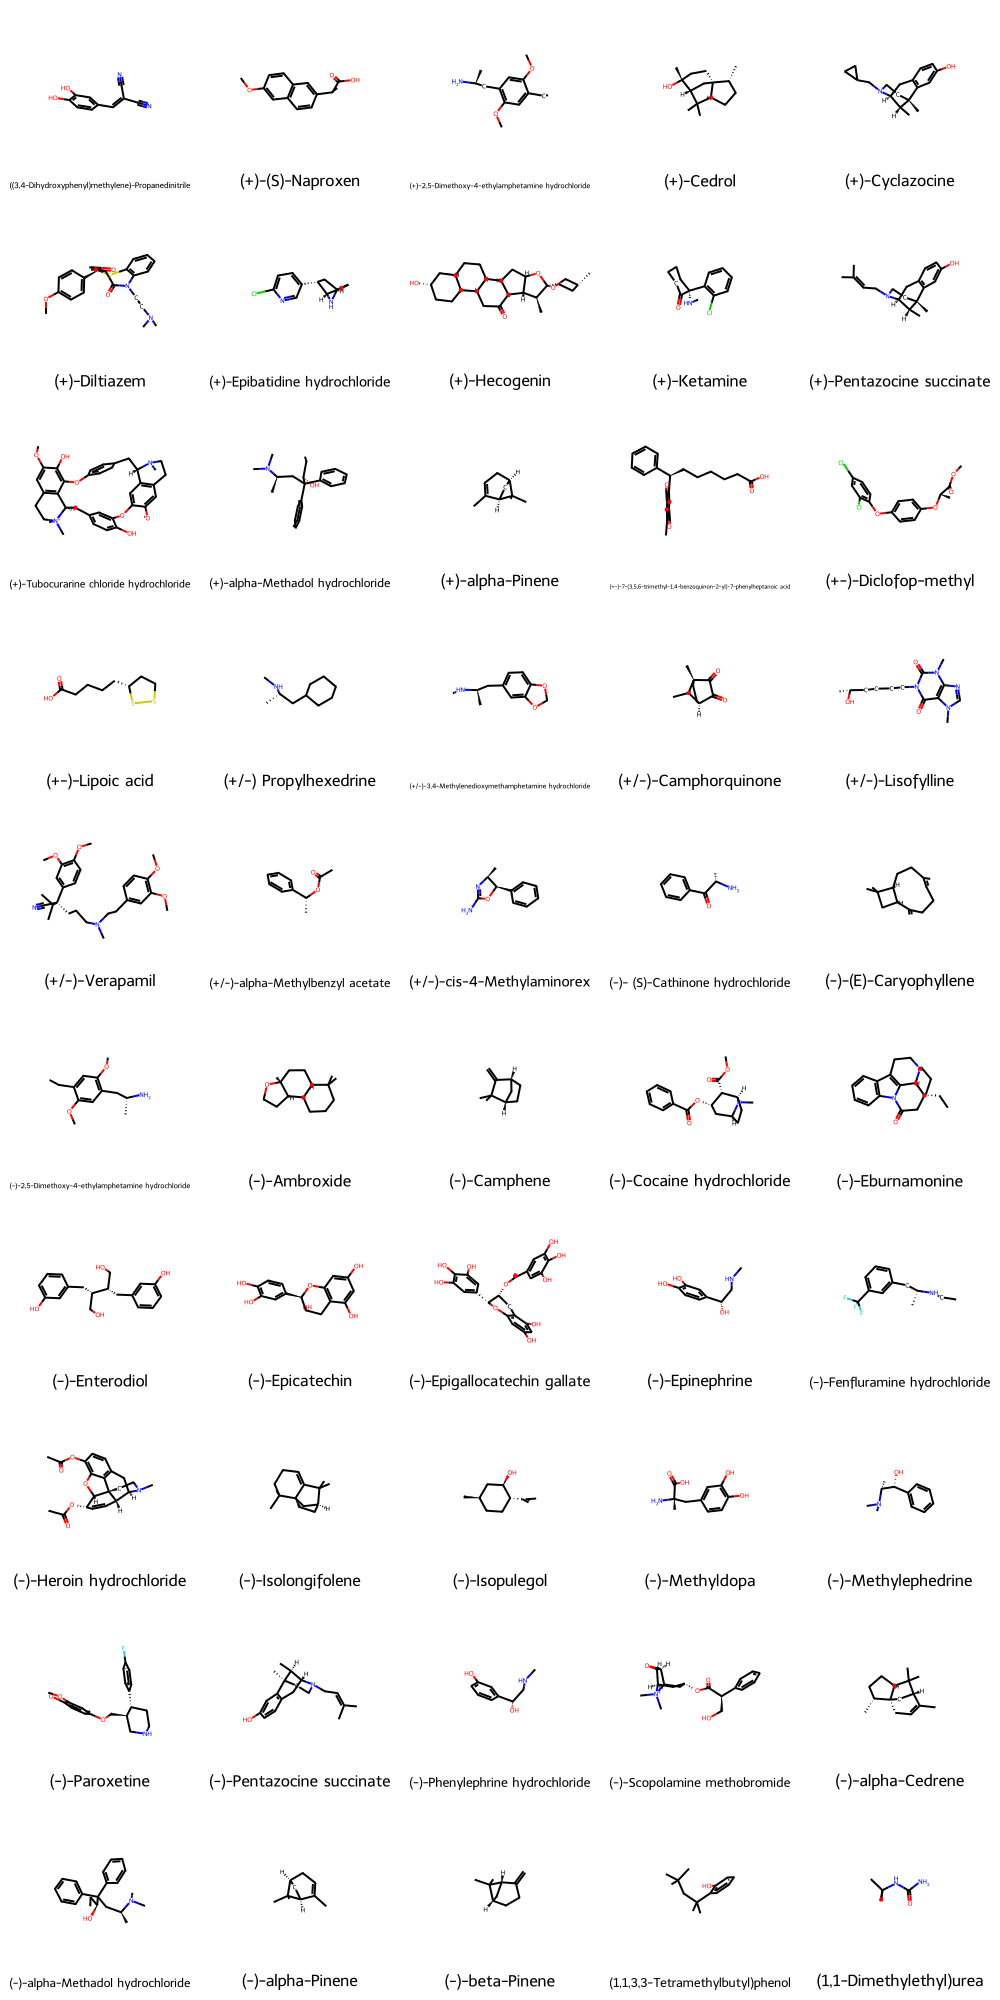

In [ ]:
# Draw the molecular structures in the dataframe
PandasTools.FrameToGridImage(Inactive, legendsCol="Compound", molsPerRow=5)

In [ ]:
Active.fillna(value='NaN', inplace=True)
Active.replace([np.inf, -np.inf], 'Infinity', inplace=True)
#save excel file with with embedded images
PandasTools.SaveXlsxFromFrame(Active,'Active.xlsx', molCol='ROMol', size=(200, 200))

Inactive.fillna(value='NaN', inplace=True)
Inactive.replace([np.inf, -np.inf], 'Infinity', inplace=True)
#save excel file with with embedded images
PandasTools.SaveXlsxFromFrame(Inactive,'Inactive.xlsx', molCol='ROMol', size=(200, 200))

In [ ]:
Training_dataset_regression.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229 entries, 32 to 6909
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   PUBCHEM_COMPOUND_CID            229 non-null    float64
 1   PUBCHEM_CONFORMER_RMSD          229 non-null    object 
 2   PUBCHEM_CONFORMER_DIVERSEORDER  229 non-null    object 
 3   PUBCHEM_MMFF94_PARTIAL_CHARGES  229 non-null    object 
 4   PUBCHEM_EFFECTIVE_ROTOR_COUNT   229 non-null    object 
 5   PUBCHEM_PHARMACOPHORE_FEATURES  229 non-null    object 
 6   PUBCHEM_HEAVY_ATOM_COUNT        229 non-null    object 
 7   PUBCHEM_ATOM_DEF_STEREO_COUNT   229 non-null    object 
 8   PUBCHEM_ATOM_UDEF_STEREO_COUNT  229 non-null    object 
 9   PUBCHEM_BOND_DEF_STEREO_COUNT   229 non-null    object 
 10  PUBCHEM_BOND_UDEF_STEREO_COUNT  229 non-null    object 
 11  PUBCHEM_ISOTOPIC_ATOM_COUNT     229 non-null    object 
 12  PUBCHEM_COMPONENT_COUNT         229 non

In [ ]:
Training_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5741 entries, 0 to 6923
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   PUBCHEM_COMPOUND_CID            5741 non-null   float64
 1   PUBCHEM_CONFORMER_RMSD          5741 non-null   object 
 2   PUBCHEM_CONFORMER_DIVERSEORDER  5741 non-null   object 
 3   PUBCHEM_MMFF94_PARTIAL_CHARGES  5731 non-null   object 
 4   PUBCHEM_EFFECTIVE_ROTOR_COUNT   5741 non-null   object 
 5   PUBCHEM_PHARMACOPHORE_FEATURES  5741 non-null   object 
 6   PUBCHEM_HEAVY_ATOM_COUNT        5741 non-null   object 
 7   PUBCHEM_ATOM_DEF_STEREO_COUNT   5741 non-null   object 
 8   PUBCHEM_ATOM_UDEF_STEREO_COUNT  5741 non-null   object 
 9   PUBCHEM_BOND_DEF_STEREO_COUNT   5741 non-null   object 
 10  PUBCHEM_BOND_UDEF_STEREO_COUNT  5741 non-null   object 
 11  PUBCHEM_ISOTOPIC_ATOM_COUNT     5741 non-null   object 
 12  PUBCHEM_COMPONENT_COUNT         5741 no

In [ ]:
In_house_test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1025 entries, 9 to 6924
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   PUBCHEM_COMPOUND_CID            1025 non-null   float64
 1   PUBCHEM_CONFORMER_RMSD          1025 non-null   object 
 2   PUBCHEM_CONFORMER_DIVERSEORDER  1025 non-null   object 
 3   PUBCHEM_MMFF94_PARTIAL_CHARGES  1023 non-null   object 
 4   PUBCHEM_EFFECTIVE_ROTOR_COUNT   1025 non-null   object 
 5   PUBCHEM_PHARMACOPHORE_FEATURES  1025 non-null   object 
 6   PUBCHEM_HEAVY_ATOM_COUNT        1025 non-null   object 
 7   PUBCHEM_ATOM_DEF_STEREO_COUNT   1025 non-null   object 
 8   PUBCHEM_ATOM_UDEF_STEREO_COUNT  1025 non-null   object 
 9   PUBCHEM_BOND_DEF_STEREO_COUNT   1025 non-null   object 
 10  PUBCHEM_BOND_UDEF_STEREO_COUNT  1025 non-null   object 
 11  PUBCHEM_ISOTOPIC_ATOM_COUNT     1025 non-null   object 
 12  PUBCHEM_COMPONENT_COUNT         1025 no

In [ ]:
#load an csv file into a dataframe using Pandas, from Georg
df_Training_dataset = pd.read_csv('/content/Training_dataset_classification.csv')

In [ ]:
df_Training_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5741 entries, 0 to 5740
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   PUBCHEM_COMPOUND_CID            5741 non-null   float64
 1   PUBCHEM_CONFORMER_RMSD          5741 non-null   float64
 2   PUBCHEM_CONFORMER_DIVERSEORDER  5741 non-null   object 
 3   PUBCHEM_MMFF94_PARTIAL_CHARGES  5731 non-null   object 
 4   PUBCHEM_EFFECTIVE_ROTOR_COUNT   5741 non-null   float64
 5   PUBCHEM_PHARMACOPHORE_FEATURES  5741 non-null   object 
 6   PUBCHEM_HEAVY_ATOM_COUNT        5741 non-null   int64  
 7   PUBCHEM_ATOM_DEF_STEREO_COUNT   5741 non-null   int64  
 8   PUBCHEM_ATOM_UDEF_STEREO_COUNT  5741 non-null   int64  
 9   PUBCHEM_BOND_DEF_STEREO_COUNT   5741 non-null   int64  
 10  PUBCHEM_BOND_UDEF_STEREO_COUNT  5741 non-null   int64  
 11  PUBCHEM_ISOTOPIC_ATOM_COUNT     5741 non-null   int64  
 12  PUBCHEM_COMPONENT_COUNT         57

In [ ]:
# Function to plot a boxplot and a histogram along the same scale

def histogram_boxplot(data, feature, figsize = (12, 7), kde = False, bins = None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,
        sharex=True,
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )
    sns.boxplot(
        data=data,
        x=feature,
        ax=ax_box2,
        showmeans=True,
        color="yellow"
    )


    if bins:
        sns.histplot(
            data=data,
            x=feature,
            kde=kde,
            ax=ax_hist2,
            bins=bins,
            palette="winter"
        )
    else:
        sns.histplot(
            data=data,
            x=feature,
            kde=kde,
            ax=ax_hist2
        )
    # Set histogram axis labels with larger font size
    ax_hist2.set_xlabel('LogKow', fontsize=24)
    ax_hist2.set_ylabel('Count', fontsize=24)
    # Increase x and y tick label sizes for histogram
    ax_hist2.tick_params(axis='x', labelsize=20)
    ax_hist2.tick_params(axis='y', labelsize=20)
    # Add mean and median lines with labels
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )
    plt.savefig('LogP distribution for Tox21', dpi=300)  # dpi=300 for high resolution

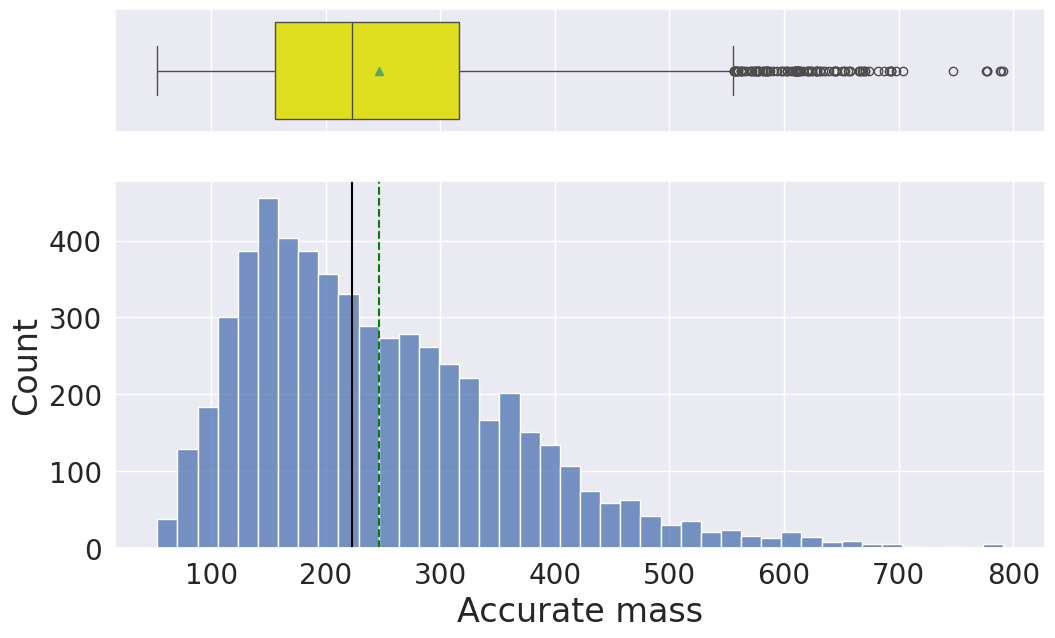

In [ ]:
histogram_boxplot(df_Training_dataset, 'MW')

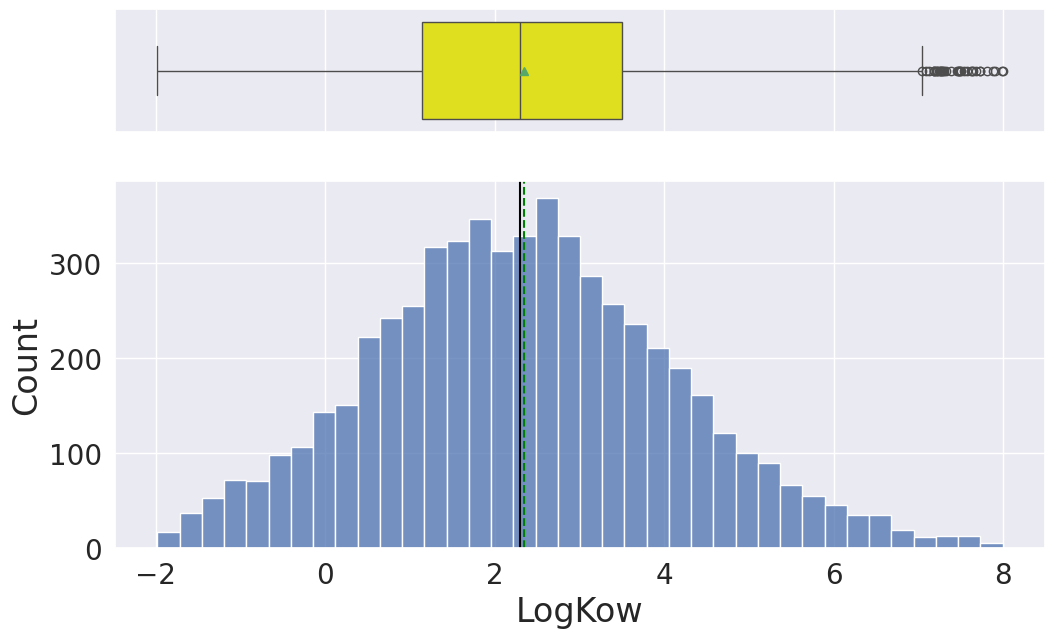

In [ ]:
histogram_boxplot(df_Training_dataset, 'LogP')
#plt.savefig('Distribution_LogP_whole.png')

1.   The distribution of molecular weight of AhR agonists is similar to that of inactive agonists. This is right-skewed distribution
2.   The distribution of LogKow of AhR agonists is also similar to that of inactive agonists. This is a normal distribution.


